# Quickstart


## Mean-field calculation of a spin-boson model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.algorithms import MeanField # import algorithm class 
from qc_lab.dynamics import serial_driver # import dynamics driver

sim = Simulation()
print('default simulation settings: ', sim.default_settings)
# default simulation settings:  {'tmax': 10, 'dt_update': 0.01, 'dt_collect': 0.1, 'num_trajs': 10, 'batch_size': 1}

# change settings to customize simulation
sim.settings.num_trajs = 200
sim.settings.batch_size = 50
sim.settings.tmax = 30
sim.settings.dt_update = 0.01
sim.settings.dt_collect = 0.1

sim.model = SpinBoson()
print('default model constants: ', sim.model.default_constants)
# default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}

sim.algorithm = MeanField()
print('default algorithm settings: ', sim.algorithm.default_settings)
# default algorithm settings:  {}

sim.state.wf_db = np.array([1, 0], dtype=complex)

data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt_update': 0.001, 'dt_collect': 0.1, 'num_trajs': 100, 'batch_size': 25}
default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {}


100%|██████████| 3001/3001 [00:01<00:00, 1780.23it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 't', 'dm_db', 'classical_energy', 'quantum_energy'])


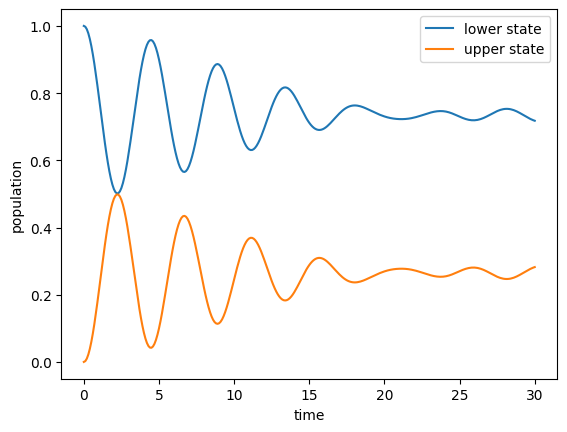

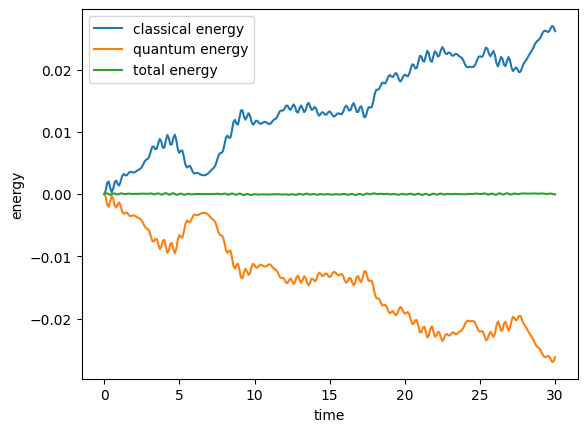

In [2]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

## FSSH calculation of a spin-boson model.

In [3]:
from qc_lab.algorithms import FewestSwitchesSurfaceHopping

sim.algorithm = FewestSwitchesSurfaceHopping()

data = serial_driver(sim)

100%|██████████| 3001/3001 [00:03<00:00, 954.79it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 't', 'dm_db', 'quantum_energy', 'classical_energy'])


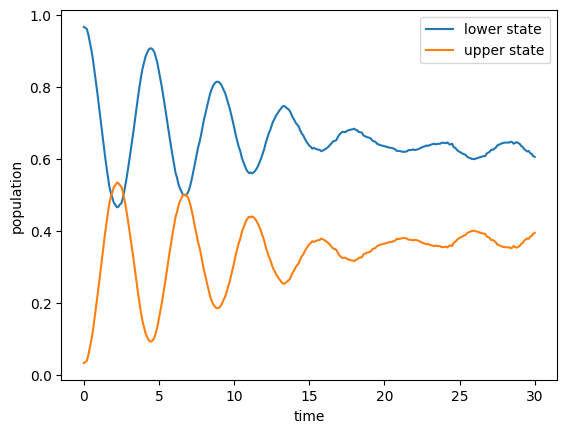

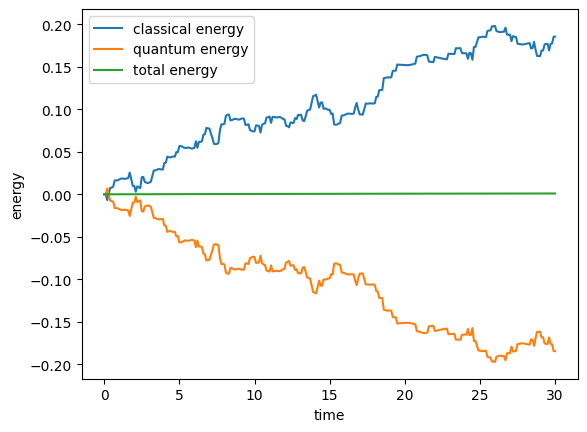

In [4]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_populations_fssh.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_energies_fssh.png')
plt.show()

## Executing a calculation in parallel

In [5]:
from qc_lab.dynamics import parallel_driver_multiprocessing

data = parallel_driver_multiprocessing(sim, num_tasks=4)

100%|██████████| 3001/3001 [00:04<00:00, 622.86it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 't', 'dm_db', 'quantum_energy', 'classical_energy'])


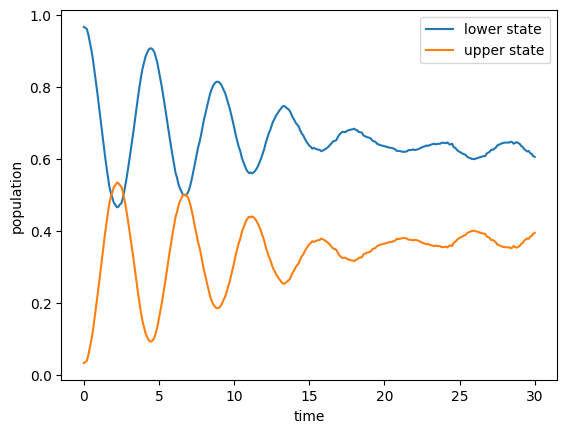

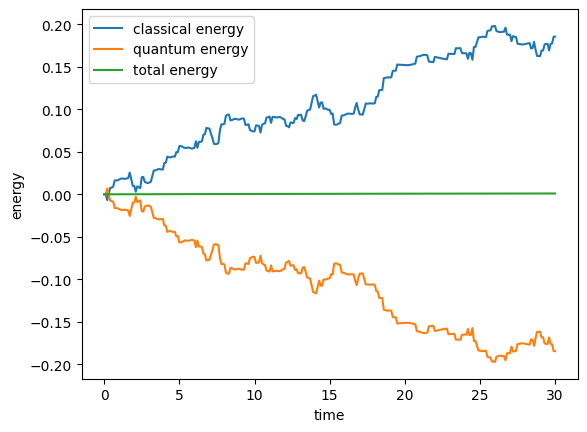

In [6]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.show()

# Model Development

In [ ]:
from qc_lab import Model
import qc_lab.ingredients as ingredients

class MinimalSpinBoson(Model):
    def __init__(self, constants=None):
        if constants is None:
            constants = {}
        self.default_constants = {
            'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1,
            'l_reorg': 0.005, 'boson_mass': 1
        }
        super().__init__(self.default_constants, constants)

    def initialize_constants_model(self):
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        char_freq = self.constants.get("W", self.default_constants.get("W"))
        boson_mass = self.constants.get(
            "boson_mass", self.default_constants.get("boson_mass")
        )
        self.constants.w = char_freq * np.tan(
            ((np.arange(num_bosons) + 1) - 0.5) * np.pi / (2 * num_bosons)
        )
        # The following constants are required by QC Lab
        self.constants.num_classical_coordinates = num_bosons
        self.constants.num_quantum_states = 2
        self.constants.classical_coordinate_weight = self.constants.w
        self.constants.classical_coordinate_mass = boson_mass * np.ones(num_bosons)

    def initialize_constants_h_c(self):
        """
        Initialize the constants for the classical Hamiltonian.
        """
        w = self.constants.get("w", self.default_constants.get("w"))
        self.constants.harmonic_frequency = w


    def initialize_constants_h_qc(self):
        """
        Initialize the constants for the quantum-classical coupling Hamiltonian.
        """
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        w = self.constants.get("w", self.default_constants.get("w"))
        l_reorg = self.constants.get("l_reorg", self.default_constants.get("l_reorg"))
        self.constants.spin_boson_coupling = w * np.sqrt(2 * l_reorg / num_bosons)

    def initialize_constants_h_q(self):
        """
        Initialize the constants for the quantum Hamiltonian. None are required in this case.
        """

    initialization_functions = [
        initialize_constants_model,
        initialize_constants_h_c,
        initialize_constants_h_qc,
        initialize_constants_h_q,
    ]

    @ingredients.vectorize_ingredient
    def h_q(self, parameters, **kwargs):
        E = self.constants.E
        V = self.constants.V
        return np.array([[E, V], [V, -E]], dtype=complex)

    @ingredients.vectorize_ingredient
    def h_qc(self, parameters, **kwargs):
        z = kwargs['z']
        g = self.constants.spin_boson_coupling
        m = self.constants.classical_coordinate_mass
        h = self.constants.classical_coordinate_weight
        h_qc = np.zeros((2, 2), dtype=complex)
        h_qc[0, 0] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z + np.conj(z)))
        h_qc[1, 1] = -h_qc[0, 0]
        return h_qc

    @ingredients.vectorize_ingredient
    def h_c(self, parameters, **kwargs):
        z = kwargs['z']
        w = self.constants.harmonic_frequency
        return np.sum(w * np.conj(z) * z)
    
    ingredients = [("h_q", h_q),
                   ("h_qc", h_qc),
                   ("h_c", h_c),
                   ]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 10
sim.settings.batch_size = 10
sim.settings.tmax = 10
sim.settings.dt_update = 0.01

# instantiate a model 
sim.model = MinimalSpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
#sim.algorithm = MeanField()
sim.algorithm = FewestSwitchesSurfaceHopping()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt_update': 0.001, 'dt_collect': 0.1, 'num_trajs': 100, 'batch_size': 25}
default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {'fssh_deterministic': False, 'gauge_fixing': 'sign_overlap'}


100%|██████████| 1001/1001 [02:58<00:00,  5.62it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 't', 'dm_db', 'quantum_energy', 'classical_energy'])


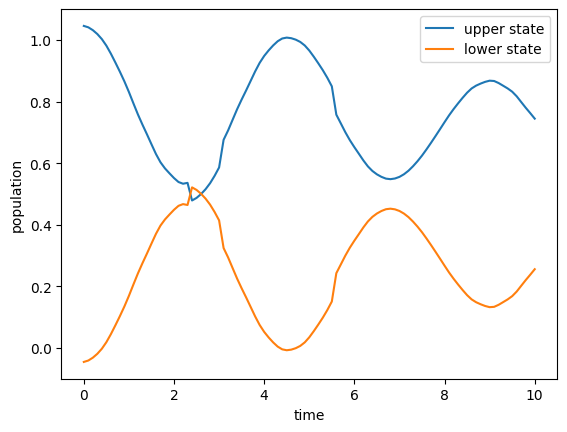

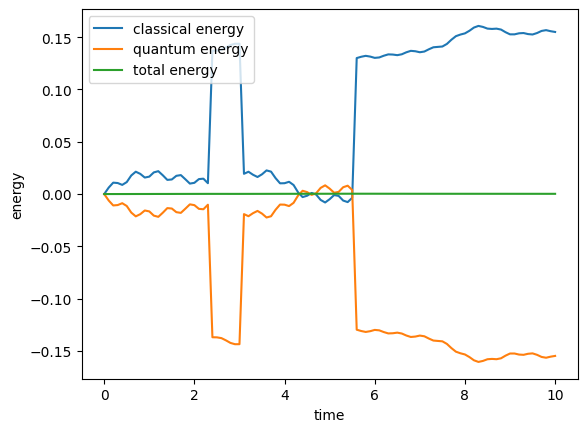

In [3]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='upper state')
plt.plot(time, populations[:,1], label='lower state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

### Upgrading the Model

In [ ]:
from qc_lab import Model
import qc_lab.ingredients as ingredients
class UpgradedSpinBoson(Model):
    def __init__(self, constants=None):
        if constants is None:
            constants = {}
        self.default_constants = {
            'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1,
            'l_reorg': 0.005, 'boson_mass': 1
        }
        self.linear_h_qc = True
        super().__init__(self.default_constants, constants)

    def initialize_constants_model(self):
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        char_freq = self.constants.get("W", self.default_constants.get("W"))
        boson_mass = self.constants.get(
            "boson_mass", self.default_constants.get("boson_mass")
        )
        self.constants.w = char_freq * np.tan(
            ((np.arange(num_bosons) + 1) - 0.5) * np.pi / (2 * num_bosons)
        )
        # The following constants are required by QC Lab
        self.constants.num_classical_coordinates = num_bosons
        self.constants.num_quantum_states = 2
        self.constants.classical_coordinate_weight = self.constants.w
        self.constants.classical_coordinate_mass = boson_mass * np.ones(num_bosons)

    def initialize_constants_h_c(self):
        """
        Initialize the constants for the classical Hamiltonian.
        """
        w = self.constants.get("w", self.default_constants.get("w"))
        self.constants.harmonic_frequency = w


    def initialize_constants_h_qc(self):
        """
        Initialize the constants for the quantum-classical coupling Hamiltonian.
        """
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        w = self.constants.get("w", self.default_constants.get("w"))
        l_reorg = self.constants.get("l_reorg", self.default_constants.get("l_reorg"))
        self.constants.spin_boson_coupling = w * np.sqrt(2 * l_reorg / num_bosons)

    def initialize_constants_h_q(self):
        """
        Initialize the constants for the quantum Hamiltonian. None are required in this case.
        """

    initialization_functions = [
        initialize_constants_model,
        initialize_constants_h_c,
        initialize_constants_h_qc,
        initialize_constants_h_q,
    ]

    def h_q(self, constants, parameters, **kwargs):
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
        else:
            batch_size = len(parameters.seed)
        E = constants.E
        V = constants.V
        h_q = np.zeros((batch_size, 2, 2), dtype=complex)
        h_q[:, 0, 0] = E
        h_q[:, 1, 1] = -E
        h_q[:, 0, 1] = V
        h_q[:, 1, 0] = V
        return h_q


    def h_qc(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)
        g = constants.spin_boson_coupling
        m = constants.classical_coordinate_mass
        h = constants.classical_coordinate_weight
        h_qc = np.zeros((batch_size, 2, 2), dtype=complex)
        h_qc[:, 0, 0] = np.sum(
            g * np.sqrt(1 / (2 * m * h))[np.newaxis, :] * (z + np.conj(z)), axis=-1
        )
        h_qc[:, 1, 1] = -h_qc[:, 0, 0]
        return h_qc

    def h_c(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)

        h = constants.classical_coordinate_weight[np.newaxis, :]
        w = constants.harmonic_frequency[np.newaxis, :]
        m = constants.classical_coordinate_mass[np.newaxis, :]
        q = np.sqrt(2 / (m * h)) * np.real(z)
        p = np.sqrt(2 * m * h) * np.imag(z)
        h_c = np.sum((1 / 2) * (((p**2) / m) + m * (w**2) * (q**2)), axis=-1)
        return h_c
    
    def dh_c_dzc(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)
        h = constants.classical_coordinate_weight
        w = constants.harmonic_frequency
        a = (1 / 2) * (
            ((w**2) / h) - h
        )
        b = (1 / 2) * (
            ((w**2) / h) + h
        )
        dh_c_dzc = b[..., :] * z + a[..., :] * np.conj(z)
        return dh_c_dzc
    
    def dh_qc_dzc(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)

        recalculate = False
        if self.dh_qc_dzc_shape is not None:
            if self.dh_qc_dzc_shape[0] != batch_size:
                recalculate = True

        if (
            self.dh_qc_dzc_inds is None
            or self.dh_qc_dzc_mels is None
            or self.dh_qc_dzc_shape is None
            or recalculate
        ):

            m = constants.classical_coordinate_mass
            g = constants.spin_boson_coupling
            h = constants.classical_coordinate_weight
            dh_qc_dzc = np.zeros((batch_size, constants.A, 2, 2), dtype=complex)
            dh_qc_dzc[:, :, 0, 0] = (g * np.sqrt(1 / (2 * m * h)))[..., :]
            dh_qc_dzc[:, :, 1, 1] = -dh_qc_dzc[..., :, 0, 0]
            inds = np.where(dh_qc_dzc != 0)
            mels = dh_qc_dzc[inds]
            shape = np.shape(dh_qc_dzc)
            self.dh_qc_dzc_inds = inds
            self.dh_qc_dzc_mels = dh_qc_dzc[inds]
            self.dh_qc_dzc_shape = shape
        else:
            inds = self.dh_qc_dzc_inds
            mels = self.dh_qc_dzc_mels
            shape = self.dh_qc_dzc_shape
        return inds, mels, shape
    
    def init_classical(model, constants, parameters, **kwargs):
        del model, parameters
        seed = kwargs.get("seed", None)
        kBT = constants.kBT
        h = constants.classical_coordinate_weight
        w = constants.harmonic_frequency
        m = constants.classical_coordinate_mass
        out = np.zeros((len(seed), constants.num_classical_coordinates), dtype=complex)
        for s, seed_value in enumerate(seed):
            np.random.seed(seed_value)
            # Calculate the standard deviations for q and p.
            std_q = np.sqrt(kBT / (m * (w**2)))
            std_p = np.sqrt(m * kBT)
            # Generate random q and p values.
            q = np.random.normal(
                loc=0, scale=std_q, size=constants.num_classical_coordinates
            )
            p = np.random.normal(
                loc=0, scale=std_p, size=constants.num_classical_coordinates
            )
            # Calculate the complex-valued classical coordinate.
            z = np.sqrt(h * m / 2) * (q + 1.0j * (p / (h * m)))
            out[s] = z
        return out
    
    ingredients = [("h_q", h_q),
                   ("h_qc", h_qc),
                   ("h_c", h_c),
                   ]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 10
sim.settings.batch_size = 10
sim.settings.tmax = 10
sim.settings.dt_update = 0.001

# instantiate a model 
sim.model = UpgradedSpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
sim.algorithm = FewestSwitchesSurfaceHopping()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_collect': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {'fssh_deterministic': False, 'gauge_fixing': 0}


100%|██████████| 10001/10001 [00:05<00:00, 1898.16it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 'quantum_energy', 'classical_energy', 'dm_db'])


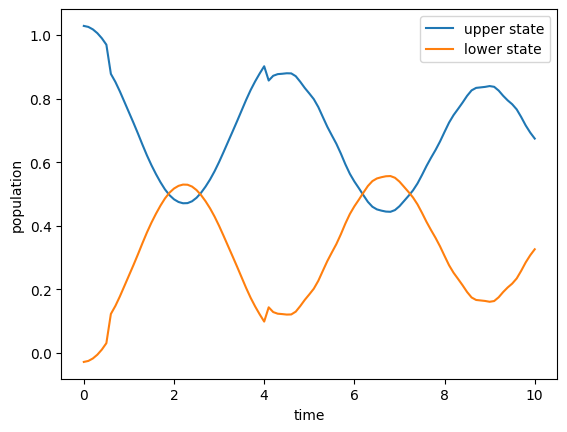

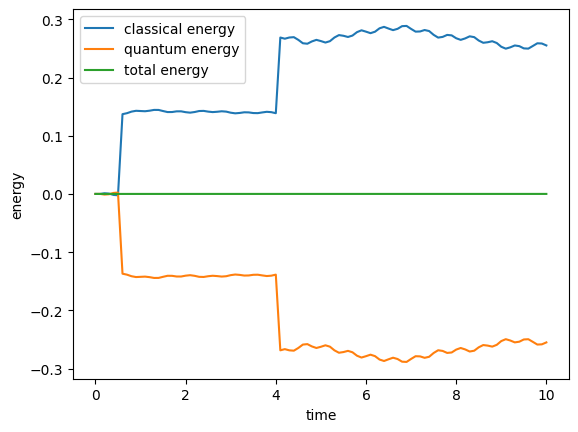

In [ ]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='upper state')
plt.plot(time, populations[:,1], label='lower state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

### Using Built-in ingredients

In [ ]:
import qc_lab.ingredients as ingredients

model = MinimalSpinBoson

model.h_q = ingredients.h_q_two_level

def initialize_constants_h_q(model):
    """
    Initialize the constants for the quantum Hamiltonian.
    """
    model.constants.two_level_00 = model.constants.get(
        "E", model.default_constants.get("E")
    )
    model.constants.two_level_11 = -model.constants.get(
        "E", model.default_constants.get("E")
    )
    model.constants.two_level_01_re = model.constants.get(
        "V", model.default_constants.get("V")
    )
    model.constants.two_level_01_im = 0

model.initialize_constants_h_q = initialize_constants_h_q
# also update the list of initialization functions
model.swap_initialization_function(model, 'initialize_constants_h_q', initialize_constants_h_q)

def initialize_constants_h_c(model):
    """
    Initialize the constants for the classical Hamiltonian.
    """
    w = model.constants.get("w", model.default_constants.get("w"))
    model.constants.harmonic_frequency = w

model.h_c = ingredients.h_c_harmonic
model.initialize_constants_h_c = initialize_constants_h_c
model.swap_initialization_function(model, 'initialize_constants_h_c', initialize_constants_h_c)

model.dh_c_dzc = ingredients.dh_c_dzc_harmonic

def initialize_constants_h_qc(model):
    """
    Initialize the constants for the quantum-classical coupling Hamiltonian.
    """
    num_bosons = model.constants.get("A", model.default_constants.get("A"))
    l_reorg = model.constants.get("l_reorg", model.default_constants.get("l_reorg"))
    m = model.constants.get("boson_mass", model.default_constants.get("boson_mass"))
    h = (
        model.constants.classical_coordinate_weight
    )  
    w = model.constants.w
    model.constants.diagonal_linear_coupling = np.zeros((2, num_bosons))
    model.constants.diagonal_linear_coupling[0] = (
        w * np.sqrt(2 * l_reorg / num_bosons) * (1 / np.sqrt(2 * m * h))
    )
    model.constants.diagonal_linear_coupling[1] = (
        -w * np.sqrt(2 * l_reorg / num_bosons) * (1 / np.sqrt(2 * m * h))
    )

model.h_qc = ingredients.h_qc_diagonal_linear
model.dh_qc_dzc = ingredients.dh_qc_dzc_diagonal_linear
model.dh_qc_dzc_inds = None
model.dh_qc_dzc_mels = None
model.dh_qc_dzc_shape = None
model.swap_initialization_function(model, 'initialize_constants_h_qc', initialize_constants_h_qc)

model.init_classical = ingredients.init_classical_boltzmann_harmonic

model.hop_function = ingredients.hop_harmonic

model.linear_h_qc = True

UpgradedBuiltInSpinBoson = model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing
from qc_lab.models import SpinBoson

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 10
sim.settings.batch_size = 10
sim.settings.tmax = 10
sim.settings.dt_update = 0.001

# instantiate a model 
sim.model = UpgradedBuiltInSpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
#sim.algorithm = MeanField()
sim.algorithm = FewestSwitchesSurfaceHopping()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_collect': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {'fssh_deterministic': False, 'gauge_fixing': 0}


100%|██████████| 10001/10001 [00:03<00:00, 2721.45it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 'quantum_energy', 'classical_energy', 'dm_db'])


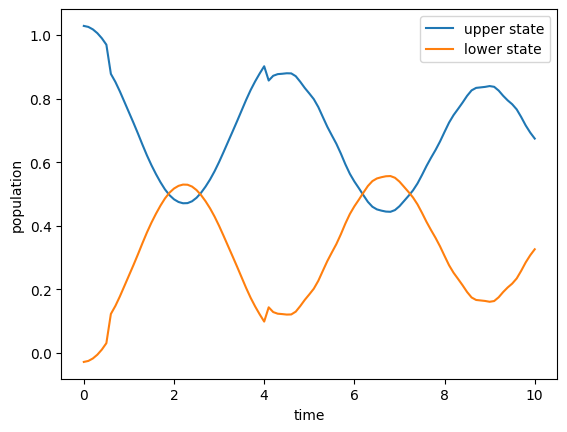

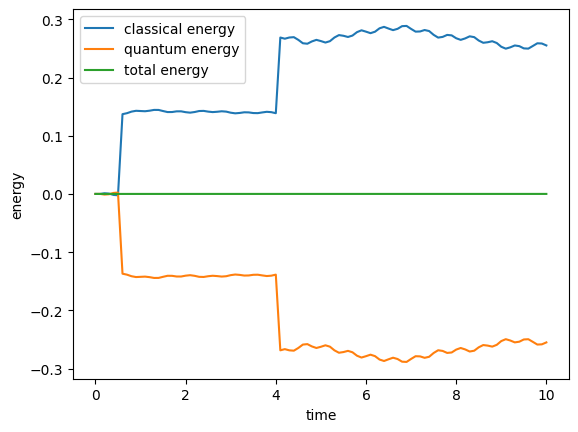

In [ ]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='upper state')
plt.plot(time, populations[:,1], label='lower state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.show()

# Algorithm Development

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab.algorithms import MeanField

# the initialization recipe
print(MeanField.initialization_recipe)

# the update recipe
print(MeanField.update_recipe)

# the output recipe
print(MeanField.collect_recipe)

def update_response_function(sim, parameters, state, **kwargs):
    # First get the diabatic wavefunction.
    wf_db = state.wf_db
    # If we are at the first timestep we can store the diabatic wavefunction in the parameters object
    if sim.t_ind == 0:
        parameters.wf_db_0 = np.copy(wf_db)
    # Next calculate the response function and store it in the state object.
    state.response_function = np.sum(np.conj(parameters.wf_db_0) * wf_db, axis=-1)
    return parameters, state

MeanField.collect_recipe.append(update_response_function)

MeanField.collect_variables.append('response_function')

[<function assign_norm_factor_mf at 0x778d0015d990>, <function MeanField.<lambda> at 0x778d0015f490>, <function MeanField.<lambda> at 0x778d0015f520>, <function MeanField.<lambda> at 0x778d0015f5b0>]
[<function MeanField.<lambda> at 0x778d0015f640>, <function MeanField.<lambda> at 0x778d0015f6d0>, <function update_wf_db_rk4 at 0x778d0015e680>]
[<function update_dm_db_mf at 0x778d0015e830>, <function MeanField.<lambda> at 0x778d0015f760>, <function MeanField.<lambda> at 0x778d0015f7f0>]


In [ ]:
from qc_lab import Simulation 
from qc_lab.dynamics import parallel_driver_multiprocessing
from qc_lab.models import SpinBoson

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 1000
sim.settings.batch_size = 250
sim.settings.tmax = 50
sim.settings.dt_update = 0.01

# instantiate a model 
sim.model = SpinBoson({'l_reorg': 0.2})
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
sim.algorithm = MeanField()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = parallel_driver_multiprocessing(sim, num_tasks=4)


default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_collect': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {}


100%|██████████| 5001/5001 [00:11<00:00, 431.81it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 'dm_db', 'classical_energy', 'quantum_energy', 'response_function'])


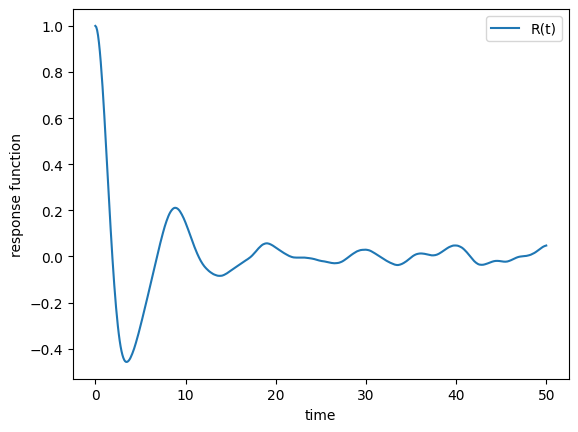

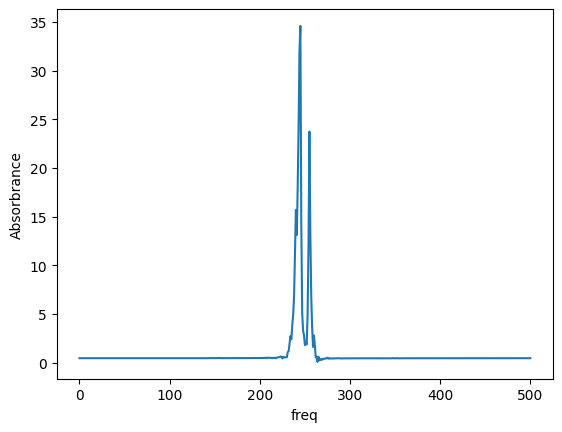

In [ ]:

# plot the data.
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
response_function = data.data_dict['response_function']
time = sim.settings.tdat_output
plt.plot(time, np.real(response_function), label='R(t)')
plt.xlabel('time')
plt.ylabel('response function')
plt.legend()
plt.show()

plt.plot(np.real(np.roll(np.fft.fft(response_function), len(time)//2)))
plt.xlabel('freq')
plt.ylabel('Absorbrance')
plt.show()

In [ ]:


def update_adiabatic_populations(sim, parameters, state, **kwargs):
    # First get the Hamiltonian and calculate its eigenvalues and eigenvectors.
    H = state.h_quantum # this is the quantum plus quantum-classical Hamiltonian.
    evals, evecs = np.linalg.eigh(H)
    # Now calculate the adiabatic wavefunction.
    wf_adb = np.einsum('tji,tj->ti', np.conj(evecs), state.wf_db)
    # Finally, calculate the populations (note that we do not sum over the batch).
    pops_adb = np.abs(wf_adb)**2
    # Store the populations in the state object.
    state.pops_adb = pops_adb
    return parameters, state

MeanField.collect_recipe.append(update_adiabatic_populations)

MeanField.collect_variables.append('pops_adb')


In [ ]:
from qc_lab import Simulation 
from qc_lab.dynamics import serial_driver
from qc_lab.models import SpinBoson

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 100
sim.settings.batch_size = 100
sim.settings.tmax = 25
sim.settings.dt_update = 0.01

# instantiate a model 
sim.model = SpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
sim.algorithm = MeanField()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dt_updateype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_collect': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'kBT': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {}


100%|██████████| 2501/2501 [00:01<00:00, 1412.50it/s]


calculated quantities: dict_keys(['seed', 'norm_factor', 'dm_db', 'classical_energy', 'quantum_energy', 'response_function', 'pops_adb'])


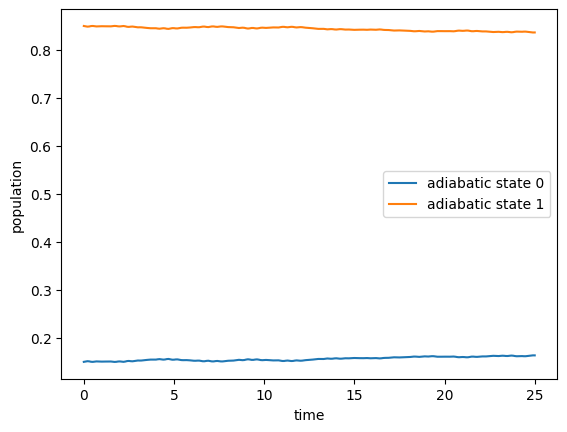

In [ ]:
print('calculated quantities:', data.data_dict.keys())
norm_factor = data.data_dict['norm_factor']
classical_energy = data.data_dict['classical_energy']
quantum_energy = data.data_dict['quantum_energy']
populations = np.real(np.einsum('tii->ti', data.data_dict['dm_db']))
adiabatic_populations = np.real(data.data_dict['pops_adb'])
time = sim.settings.tdat_output
plt.plot(time, adiabatic_populations[:,0], label='adiabatic state 0')
plt.plot(time, adiabatic_populations[:,1], label='adiabatic state 1')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.show()

Task #0 <function FewestSwitchesSurfaceHopping._assign_eigvecs_to_state at 0x738e5dd65090>
Task #1 <function FewestSwitchesSurfaceHopping._update_z_rk4 at 0x738e5dd65240>
Task #2 <function FewestSwitchesSurfaceHopping._update_wf_db_eigs at 0x738e5dd652d0>
Task #3 <function FewestSwitchesSurfaceHopping._update_h_quantum at 0x738e5dd64ee0>
Task #4 <function FewestSwitchesSurfaceHopping._diagonalize_matrix at 0x738e5dd64f70>
Task #5 <function FewestSwitchesSurfaceHopping._gauge_fix_eigs_update at 0x738e5dd65360>
Task #6 <function update_hop_probs_fssh at 0x738e5dd37c70>
Task #7 <function update_hop_inds_fssh at 0x738e5dd37d00>
Task #8 <function update_hop_vals_fssh at 0x738e5dd37d90>
Task #9 <function update_z_hop_fssh at 0x738e5dd37e20>
Task #10 <function update_act_surf_hop_fssh at 0x738e5dd37eb0>
Task #11 <function update_act_surf_wf at 0x738e5dd376d0>
Task #0 <function FewestSwitchesSurfaceHopping._assign_eigvecs_to_state at 0x738e5dd65090>
Task #1 <function FewestSwitchesSurfaceHoppi

100%|██████████| 3001/3001 [01:02<00:00, 48.36it/s]


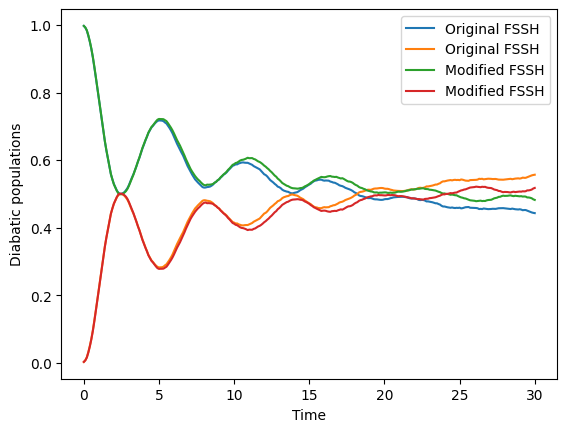

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def update_z_reverse_frustrated_fssh(algorithm, sim, parameters, state, **kwargs):
        """
        Reverse the velocities of frustrated trajectories in the FSSH algorithm.
        """
        # get the indices of trajectories that were frustrated
        # (i.e., did not successfully hop but were eligible to hop)
        frustrated_indices = state.hop_ind[~state.hop_successful]
        # reverse the velocities for these indices, in the complex calssical coordinate 
        # formalism, this means conjugating the z coordiante.
        state.z[frustrated_indices] = state.z[frustrated_indices].conj()
        return parameters, state
from qc_lab.algorithms import FewestSwitchesSurfaceHopping

# Create an instance of the FSSH algorithm
fssh_algorithm = FewestSwitchesSurfaceHopping()

# Print the update recipe to see where to insert our task
for ind, task in enumerate(fssh_algorithm.update_recipe):
    print(f"Task #{ind}", task)

# Insert the new task into the update recipe
fssh_algorithm.update_recipe.insert(
    10,
    update_z_reverse_frustrated_fssh
)
for ind, task in enumerate(fssh_algorithm.update_recipe):
    print(f"Task #{ind}", task)


from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.dynamics import parallel_driver_multiprocessing

# Create an instance of the original FSSH algorithm
original_fssh_algorithm = FewestSwitchesSurfaceHopping()


sim = Simulation()

sim.settings.num_trajs = 4000
sim.settings.batch_size = 1000
sim.settings.tmax = 30
sim.settings.dt_update = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.1,
    'boson_mass':1.0,
    'kBT':1.0,

})
sim.state.wf_db= np.array([1,0], dtype=complex)
# Run the simulation with the original FSSH algorithm
sim.algorithm = original_fssh_algorithm
data_original = parallel_driver_multiprocessing(sim)

# Now run the simulation with the modified FSSH algorithm
sim.algorithm = fssh_algorithm
data_modified = parallel_driver_multiprocessing(sim)

t_original = data_original.data_dict['t']
pops_original = np.real(np.einsum('tii->ti',data_original.data_dict['dm_db']))
t_modified = data_modified.data_dict['t']
pops_modified = np.real(np.einsum('tii->ti',data_modified.data_dict['dm_db']))
plt.plot(t_original, pops_original, label='Original FSSH')
plt.plot(t_modified, pops_modified, label='Modified FSSH')
plt.xlabel('Time')
plt.ylabel('Diabatic populations')
plt.legend()
#plt.savefig('modified_fssh_populations.png')
plt.show()

100%|██████████| 10001/10001 [00:02<00:00, 3859.72it/s]


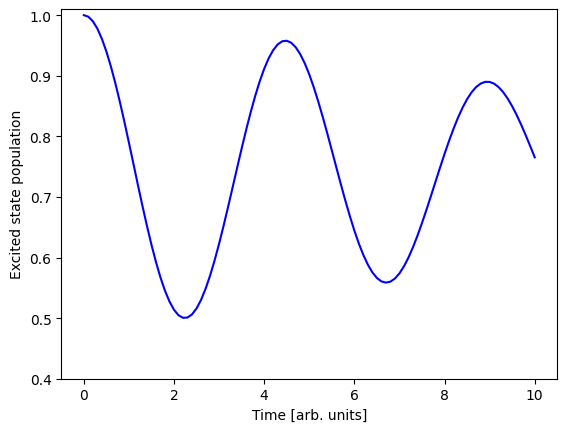

100


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation
from qc_lab.models import SpinBoson
from qc_lab.algorithms import MeanField
from qc_lab.dynamics import serial_driver


# Initialize the simulation object.
sim = Simulation()
# Equip it with a SpinBoson model object.
sim.model = SpinBoson()
# Attach the MeanField algorithm.
sim.algorithm = MeanField()
# Initialize the diabatic wavefunction. 
# Here, the first state is the upper state and the second is the lower state.
sim.state.wf_db = np.array([1, 0], dtype=complex)
# Run the simulation.
data = serial_driver(sim)
sim.initialize_timesteps()

# Pull out the time.
t = data.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations = np.real(np.einsum("tii->ti", data.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="blue")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.savefig('mf.png')
plt.show()
print(data.data_dict['norm_factor'])


100%|██████████| 10001/10001 [00:02<00:00, 3621.63it/s]


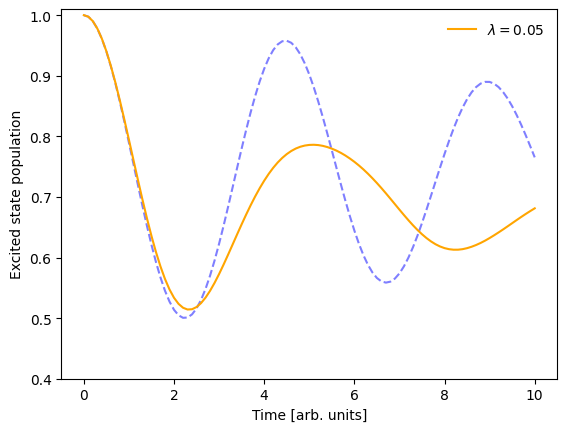

In [16]:
sim.model.constants.l_reorg = 0.05


data_1 = serial_driver(sim)

plt.plot(data_1.data_dict["t"], np.real(data_1.data_dict["dm_db"][:,0,0]), color='orange',label=r'$\lambda = 0.05$',zorder=5)
plt.plot(data.data_dict["t"], np.real(data.data_dict["dm_db"][:,0,0]), color='blue', linestyle='dashed',alpha=0.5)
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.legend(frameon=False)
plt.savefig('mf_lreorg.png')
plt.show()

100%|██████████| 10001/10001 [00:06<00:00, 1644.38it/s]


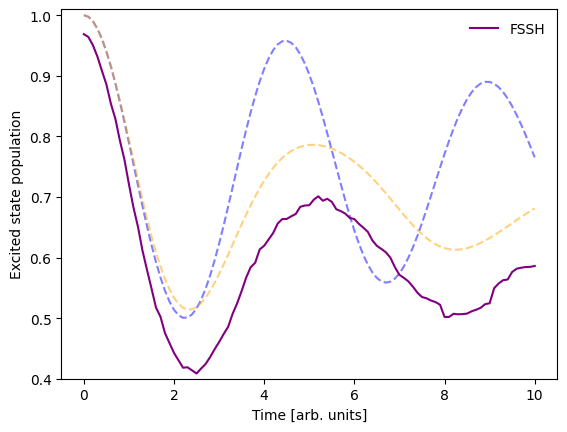

In [17]:
from qc_lab.algorithms import FewestSwitchesSurfaceHopping

sim.algorithm = FewestSwitchesSurfaceHopping()


data_fssh = serial_driver(sim)

plt.plot(data_1.data_dict["t"], np.real(data_1.data_dict["dm_db"][:,0,0]), color='orange', linestyle='dashed',alpha=0.5,zorder=4)
plt.plot(data.data_dict["t"], np.real(data.data_dict["dm_db"][:,0,0]), color='blue', linestyle='dashed',alpha=0.5,zorder=3)
plt.plot(data_fssh.data_dict["t"], np.real(data_fssh.data_dict["dm_db"][:,0,0]), color='purple',label=r'FSSH',zorder=5)
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
#plt.savefig('fssh_lreorg.png')
plt.legend(frameon=False)
plt.savefig('fssh_lreorg.png')
plt.show()

Task #0 <function FewestSwitchesSurfaceHopping._assign_eigvecs_to_state at 0x7c0a29f681f0>
Task #1 <function FewestSwitchesSurfaceHopping._update_z_rk4 at 0x7c0a29f683a0>
Task #2 <function FewestSwitchesSurfaceHopping._update_wf_db_eigs at 0x7c0a29f68430>
Task #3 <function FewestSwitchesSurfaceHopping._update_h_quantum at 0x7c0a29f68040>
Task #4 <function FewestSwitchesSurfaceHopping._diagonalize_matrix at 0x7c0a29f680d0>
Task #5 <function FewestSwitchesSurfaceHopping._gauge_fix_eigs_update at 0x7c0a29f684c0>
Task #6 <function update_hop_probs_fssh at 0x7c0a29f62ef0>
Task #7 <function update_hop_inds_fssh at 0x7c0a29f62f80>
Task #8 <function update_hop_vals_fssh at 0x7c0a29f63010>
Task #9 <function update_z_hop_fssh at 0x7c0a29f630a0>
Task #10 <function update_act_surf_hop_fssh at 0x7c0a29f63130>
Task #11 <function update_act_surf_wf at 0x7c0a29f62950>
Task #0 <function FewestSwitchesSurfaceHopping._assign_eigvecs_to_state at 0x7c0a29f681f0>
Task #1 <function FewestSwitchesSurfaceHoppi

100%|██████████| 10001/10001 [00:07<00:00, 1422.84it/s]


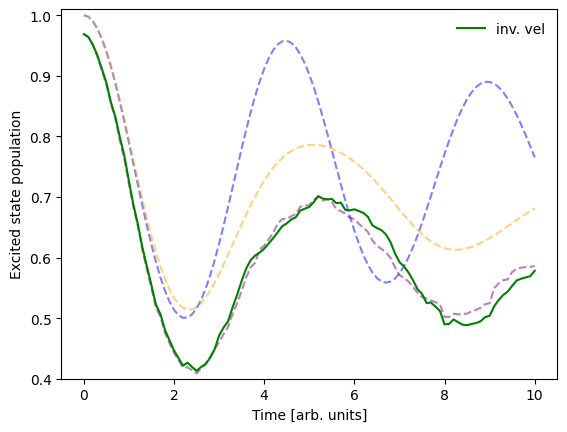

In [18]:

def update_z_reverse_frustrated_fssh(algorithm, sim, parameters, state, **kwargs):
        """
        Reverse the velocities of frustrated trajectories in the FSSH algorithm.
        """
        # get the indices of trajectories that were frustrated
        # (i.e., did not successfully hop but were eligible to hop)
        frustrated_indices = state.hop_ind[~state.hop_successful]
        # reverse the velocities for these indices, in the complex calssical coordinate 
        # formalism, this means conjugating the z coordiante.
        state.z[frustrated_indices] = state.z[frustrated_indices].conj()
        return parameters, state


# Print the update recipe to see where to insert our task
for ind, task in enumerate(sim.algorithm.update_recipe):
    print(f"Task #{ind}", task)

# Insert the new task into the update recipe
sim.algorithm.update_recipe.insert(
    10,
    update_z_reverse_frustrated_fssh
)
for ind, task in enumerate(sim.algorithm.update_recipe):
    print(f"Task #{ind}", task)

data_fssh_reverse = serial_driver(sim)

plt.plot(data_1.data_dict["t"], np.real(data_1.data_dict["dm_db"][:,0,0]), color='orange', linestyle='dashed',alpha=.5,zorder=3)#, label=r'$\lambda = 0.005$')
plt.plot(data.data_dict["t"], np.real(data.data_dict["dm_db"][:,0,0]), color='blue', linestyle='dashed',alpha=.5,zorder=2)
plt.plot(data_fssh.data_dict["t"], np.real(data_fssh.data_dict["dm_db"][:,0,0]), color='purple',linestyle='dashed',alpha=.5,zorder=4)#,label=r'$\lambda = 0.005$' + ' (FSSH)')
plt.plot(data_fssh_reverse.data_dict["t"], np.real(data_fssh_reverse.data_dict["dm_db"][:,0,0]), color='green',label=r'inv. vel',zorder=5)
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
#plt.savefig('fssh_lreorg.png')
plt.legend(frameon=False)
plt.savefig('fssh_lreorg_inv_vel.png')
plt.show()

In [19]:
from qc_lab.ingredients import vectorize_ingredient

@vectorize_ingredient
def h_qc(model, parameters, **kwargs):
    """
    A coupling term that couples the boson coordinates to the off-diagonal elements of the quantum Hamiltonian.
    """
    # First we'll get the z-coordinate from the keyword arguments
    z = kwargs['z']
    # Next we'll get the Required constants from the constants object.
    m = model.constants.classical_coordinate_mass
    h = model.constants.classical_coordinate_weight
    g = model.constants.w * np.sqrt(2 * model.constants.l_reorg / model.constants.A)
    # Now we can construct the empty Hamiltonian matrix as a 2x2 complex array.
    h_qc = np.zeros((2, 2), dtype=complex)
    # Then we can populate the off-diagonal elements of the Hamiltonian matrix.
    h_qc[0, 1] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z + np.conj(z)))
    h_qc[1, 0] = np.conj(h_qc[0, 1])
    return h_qc


sim.model.ingredients.append(("h_qc", h_qc))

sim.model.ingredients.append(("dh_qc_dzc", None))

data_fssh_reverse_new_couple = serial_driver(sim)

100%|██████████| 10001/10001 [00:11<00:00, 896.28it/s]


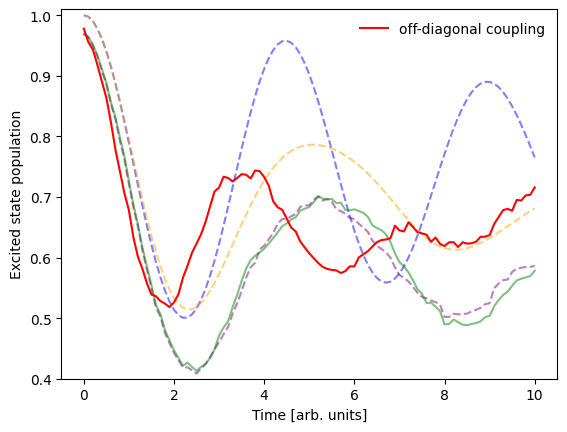

In [21]:
plt.plot(data_1.data_dict["t"], np.real(data_1.data_dict["dm_db"][:,0,0]), color='orange', linestyle='dashed',alpha=.5,zorder=3)#, label=r'$\lambda = 0.005$')
plt.plot(data.data_dict["t"], np.real(data.data_dict["dm_db"][:,0,0]), color='blue', linestyle='dashed',alpha=.5,zorder=2)
plt.plot(data_fssh.data_dict["t"], np.real(data_fssh.data_dict["dm_db"][:,0,0]), color='purple',linestyle='dashed',alpha=.5,zorder=4)#,label=r'$\lambda = 0.005$' + ' (FSSH)')
plt.plot(data_fssh_reverse.data_dict["t"], np.real(data_fssh_reverse.data_dict["dm_db"][:,0,0]), color='green',zorder=5, alpha=0.5)
plt.plot(data_fssh_reverse_new_couple.data_dict["t"], np.real(data_fssh_reverse_new_couple.data_dict["dm_db"][:,0,0]), color='red',label=r'off-diagonal coupling',zorder=5)
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
#plt.savefig('fssh_lreorg.png')
plt.legend(frameon=False)
plt.savefig('fssh_lreorg_inv_vel_offdiag.png')
plt.show()

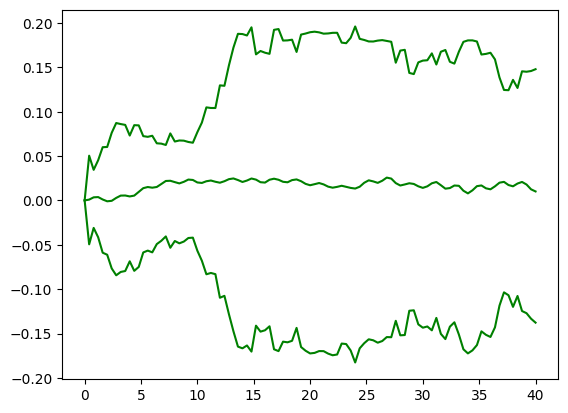

In [ ]:
eq = data_fssh_reverse_new_couple.data_dict["quantum_energy"]
ec = data_fssh_reverse_new_couple.data_dict["classical_energy"]
plt.plot(data_fssh_reverse_new_couple.data_dict["t"], eq - eq[0], color='green',label=r'$\lambda = 0.005$' + ' (FSSH) + inv. vel',zorder=5)
plt.plot(data_fssh_reverse_new_couple.data_dict["t"], ec - ec[0], color='green',label=r'$\lambda = 0.005$' + ' (FSSH) + inv. vel',zorder=5)
plt.plot(data_fssh_reverse_new_couple.data_dict["t"], ec - ec[0] + eq - eq[0], color='green',label=r'$\lambda = 0.005$' + ' (FSSH) + inv. vel',zorder=5)


In [ ]:
sim.settings.num_trajs = 1000
# you can also change the batch size if you want to run more trajectories in each batch.
sim.settings.batch_size = 1000
data_fssh_1000 = serial_driver(sim)


100%|██████████| 10001/10001 [01:32<00:00, 108.44it/s]


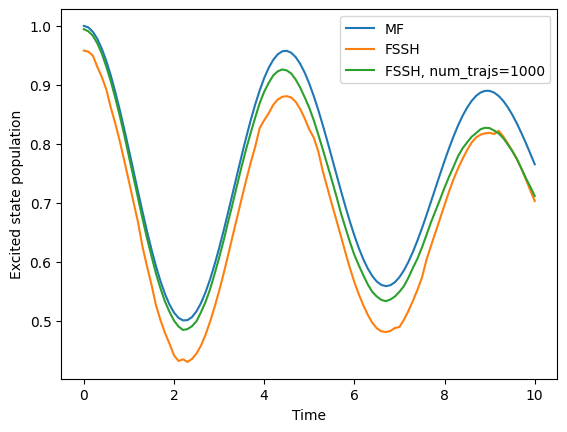

In [ ]:

plt.plot(data.data_dict["t"], np.real(data.data_dict["dm_db"][:,0,0]), label='MF')
plt.plot(data_fssh.data_dict["t"], np.real(data_fssh.data_dict["dm_db"][:,0,0]), label='FSSH')
plt.plot(data_fssh_1000.data_dict["t"], np.real(data_fssh_1000.data_dict["dm_db"][:,0,0]), label='FSSH, num_trajs=1000')
plt.xlabel('Time')
plt.ylabel('Excited state population')
plt.legend()
#plt.savefig('fssh_numtrajs.png')
plt.show()

100%|██████████| 10001/10001 [01:32<00:00, 107.65it/s]


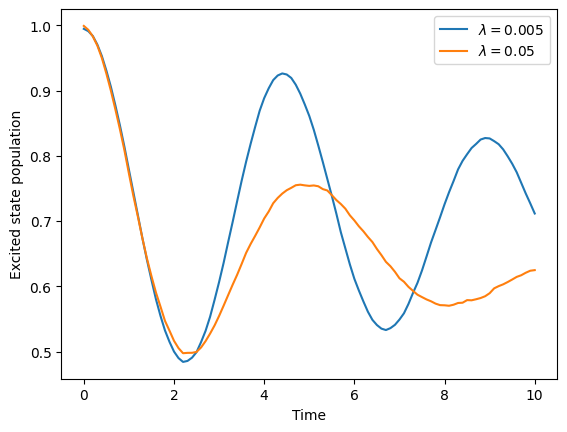

In [ ]:
sim.model.constants.l_reorg = 0.05

# Now let's run the simulation again
data_fssh_1000_05 = serial_driver(sim)

plt.plot(data_fssh_1000.data_dict["t"], np.real(data_fssh_1000.data_dict["dm_db"][:,0,0]), label=r'$\lambda = 0.005$')
plt.plot(data_fssh_1000_05.data_dict["t"], np.real(data_fssh_1000_05.data_dict["dm_db"][:,0,0]), label=r'$\lambda = 0.05$')
plt.xlabel('Time')
plt.ylabel('Excited state population')
#plt.savefig('fssh_lreorg.png')
plt.legend()
plt.show()

In [ ]:
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing
import time

sim.settings.num_trajs = 1000
sim.settings.batch_size = 125

st = time.time()
data_parallel = parallel_driver_multiprocessing(sim)
et = time.time()
print(f"Parallel driver took {et-st:.2f} seconds to run.")
st = time.time()
data_serial = serial_driver(sim)
et = time.time()
print(f"Serial driver took {et-st:.2f} seconds to run.")

100%|██████████| 10001/10001 [00:36<00:00, 274.42it/s]


Parallel driver took 36.65 seconds to run.


100%|██████████| 10001/10001 [00:15<00:00, 639.75it/s]

Serial driver took 125.88 seconds to run.


In [ ]:
125.88/36.65

3.434652114597544

In [ ]:
344/147

2.3401360544217686

100%|██████████| 10001/10001 [00:12<00:00, 782.32it/s]


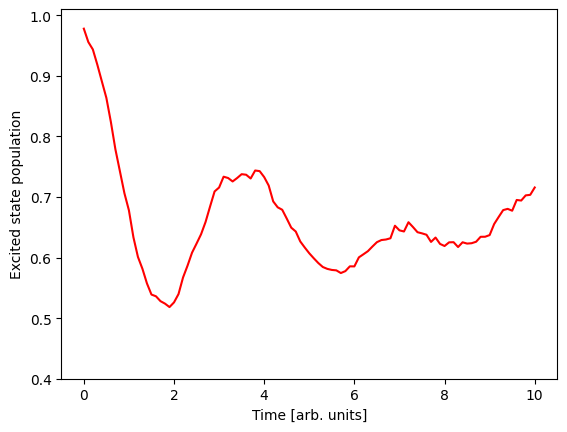

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation
from qc_lab.models import SpinBoson
from qc_lab.algorithms import FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver
from qc_lab.ingredients import vectorize_ingredient

def update_z_reverse_frustrated_fssh(algorithm, sim, parameters, state):
    """
    Reverse the velocities of frustrated trajectories in the FSSH algorithm.
    """
    # Get the indices of trajectories that were frustrated
    # (i.e., did not successfully hop but were eligible to hop).
    frustrated_indices = state.hop_ind[~state.hop_successful]
    # Reverse the velocities for these indices, in the complex classical coordinate 
    # formalism, this means conjugating the z coordinate.
    state.z[frustrated_indices] = state.z[frustrated_indices].conj()
    return parameters, state

@vectorize_ingredient
def h_qc(model, parameters, **kwargs):
    """
    A coupling term that couples the boson coordinates to the off-diagonal elements of the quantum Hamiltonian.
    """
    # First we'll get the z-coordinate from the keyword arguments
    z = kwargs['z']
    # Next we'll get the Required constants from the constants object.
    m = model.constants.classical_coordinate_mass
    h = model.constants.classical_coordinate_weight
    g = model.constants.w * np.sqrt(2 * model.constants.l_reorg / model.constants.A)
    # Now we can construct the empty Hamiltonian matrix as a 2x2 complex array.
    h_qc = np.zeros((2, 2), dtype=complex)
    # Then we can populate the off-diagonal elements of the Hamiltonian matrix.
    h_qc[0, 1] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z + np.conj(z)))
    h_qc[1, 0] = np.conj(h_qc[0, 1])
    return h_qc

# Initialize the simulation object.
sim = Simulation()
# Equip it with a spin-boson model object.
sim.model = SpinBoson()
# Change the reorganization energy.
sim.model.constants.l_reorg = 0.05
# Add the new coupling term to the model's ingredients.
sim.model.ingredients.append(("h_qc", h_qc))
# Overwrite the analytic gradient ingredient, which is no longer correct for the new coupling.
sim.model.ingredients.append(("dh_qc_dzc", None))
# Attach the FSSH algorithm.
sim.algorithm = FewestSwitchesSurfaceHopping()
# Insert the function for reversing velocities as a task into the update recipe.
sim.algorithm.update_recipe.insert(10, update_z_reverse_frustrated_fssh)
# Initialize the diabatic wavevector. 
# Here, the first vector element refers to the upper state and the second
# element refers to the lower state.
sim.state.wf_db = np.array([1, 0], dtype=complex)

# Run the simulation.
data = serial_driver(sim)

# Pull out the time.
t = data.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations = np.real(np.einsum("tii->ti", data.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="red")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.show()